# narrative-subcorpora — complete demo

This notebook demonstrates every feature of the package, with an emphasis on the new **grouped scoring** and **active learning** functionality.

## Contents

1. Setup
2. Loading events
3. Time-window querying
4. Standard (flat) scoring methods
5. **Grouped scoring** — the new feature
6. Combination strategies compared
7. Diagnostics and visualisation
8. Filtering and export
9. Comparing flat vs grouped scoring in detail
10. Another event: treinkaping bij De Punt
11. Multiple events in a loop
12. Weighted sum strategy with custom weights
13. Advanced: embedding-based scoring (optional)
14. **Active learning** — refine selection interactively

## 1 — Setup

In [ ]:
from narrative_subcorpora import (
    Corpus, Event, ActiveLearner,
    selection_report, score_distribution, group_score_distribution,
)
from narrative_subcorpora.score import (
    group_term_scores, combine_group_scores,
    term_frequency_score, combined_score,
)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 120

CORPUS_PATH  = "/home/adapt/Documents/adapt/data/delpher/data/news.parquet"
EVENTS_PATH  = "events.json"
TEXT_COL     = "ocr"
DATE_COL     = "date"

corpus = Corpus(CORPUS_PATH, text_col=TEXT_COL, date_col=DATE_COL)
print("Corpus loaded")
info = corpus.describe()
print(f"  {info['num_rows']:,} rows, {info['num_columns']} columns")
print("  Columns:", [c['name'] for c in info['columns']])

## 2 — Loading events

Each event now has a flat `terms` list *and* an optional `term_groups` dict that categorises seed terms by semantic type.

In [2]:
events = Event.load_all(EVENTS_PATH)

print(f"{'Label':<22} {'Full name':<35} {'Date':<12} {'# terms':>8} {'Groups'}")
print("-" * 90)
for ev in events:
    groups = ', '.join(ev.term_groups) if ev.term_groups else '—'
    print(f"{ev.label:<22} {ev.full_name:<35} {str(ev.start_date):<12} {len(ev.terms):>8}   {groups}")

Label                  Full name                           Date          # terms Groups
------------------------------------------------------------------------------------------
spaanse_griep          Spaanse Griep                       1918-07-01        112   location, event_type, symptoms, response
zeven_prov             Muiterij op De Zeven Provinciën     1933-02-04         88   location, vessel, event_type, actors
cubacrisis             Cubacrisis                          1962-10-22         74   location, event_type, weapons, actors
kaping                 Treinkaping bij De Punt             1977-05-23         64   location, vehicle, event_type, actors
bijlmer                Bijlmerramp                         1992-10-04         62   location, aircraft, event_type, impact
harmelen               Treinramp bij Harmelen              1962-01-08        111   location, vehicle, event_type, conditions, impact
watersnood             Watersnoodramp 1953                 1953-02-01         66

In [3]:
# Inspect the watersnood event in detail
event = Event.from_json(EVENTS_PATH, "watersnood")
print(event)
print()
for group, terms in event.term_groups.items():
    print(f"  {group:<15}: {', '.join(terms[:6])}{' ...' if len(terms) > 6 else ''}")

Watersnoodramp 1953 (1953-02-01, 66 terms, 4 groups)

  location       : zeeland, walcheren, schouwen, duiveland, tholen, beveland ...
  event_type     : watersnood, watersnoodramp, waterramp, overstroming, overstrooming, inundatie ...
  cause          : springtij, springvloed, springgetij, noordwesterstorm, opstuwing, watermassa ...
  impact         : slachtoffers, doden, verdronken, vermisten, dakloos, evacuatie ...


## 3 — Time-window querying

Use `.after()`, `.before()`, `.around()`, or `.between()` to slice the corpus by date.

In [4]:
# Six months after the 1953 flood
window = corpus.after(event, months=6)
print(f".after(watersnood, months=6): {len(window):,} articles")

# One month before
# before = corpus.before(event, months=1)
# print(f".before(watersnood, months=1): {len(before):,} articles")

# # Symmetric window
# around = corpus.around(event, months_before=1, months_after=6)
# print(f".around(watersnood, months_before=1, months_after=6): {len(around):,} articles")

# # Absolute date range
# custom = corpus.between("1953-01-01", "1953-12-31")
# print(f".between('1953-01-01', '1953-12-31'): {len(custom):,} articles")

.after(watersnood, months=6): 111,317 articles


## 4 — Standard (flat) scoring methods

The original scoring methods treat all seed terms equally.

In [5]:
# Chain all flat scoring methods
scored_flat = (
    corpus
    .after(event, months=6)
    .score(terms=event.terms)                     # term coverage -> "score"
    .score_tfidf(terms=event.terms)               # TF-IDF        -> "score_tfidf"
    .score_bm25(terms=event.terms)                # BM25          -> "score_bm25"
    .score_cluster(terms=event.terms, window=50)  # clustering    -> "score_cluster"
)

df_flat = scored_flat.to_dataframe()
flat_score_cols = ["score", "score_tfidf", "score_bm25", "score_cluster"]
df_flat[flat_score_cols].describe().round(4)

,score,score_tfidf,score_bm25,score_cluster
count,111317.0000,111317.0000,111317.0000,111317.0000
mean,0.0053,0.0064,0.7637,0.0020
std,0.0138,0.0302,2.8407,0.0066
min,0.0000,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0000,0.0000
75%,0.0000,0.0000,0.0000,0.0000
max,0.2727,0.9890,53.1730,0.1364


In [ ]:
# Weighted term scoring — give more important terms a higher weight
weights = {
    "watersnood":    3.0,   # very specific
    "watersnoodramp": 3.0,
    "dijkbreuk":     2.5,
    "overstroming":  2.0,
    "zeeland":       1.5,
    "walcheren":     1.5,
    "slachtoffers":  1.0,
    "evacuatie":     1.0,
    "springtij":     1.0,
    "vloed":         0.5,   # quite generic
}
scored_weighted = corpus.after(event, months=6).score_weighted(weights)
print("Weighted score stats:")
print(scored_weighted.to_dataframe()["score_weighted"].describe().round(4))

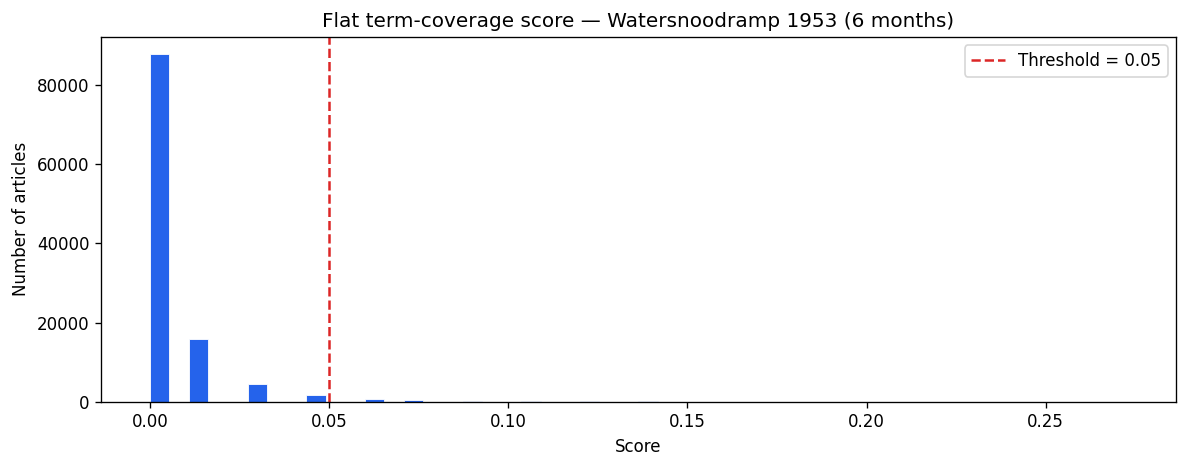

In [6]:
# Distribution of flat term-coverage score
fig = score_distribution(scored_flat, score_col="score", threshold=0.05, bins=50)
plt.title("Flat term-coverage score — Watersnoodramp 1953 (6 months)")
plt.show()

## 5 — Grouped scoring (new)

The key insight: a flat score cannot distinguish between an article that mentions *Zeeland* five times (location only) and one that mentions *overstroming* five times (event type only). Both score the same — but neither is as good as one that mentions both.

**Grouped scoring** scores each semantic category independently and then combines them. With the default **geometric mean**, an article must have non-zero evidence in *every* group to score above zero.

In [ ]:
# Low-level: per-group scores on a single text
example_texts = [
    "De watersnood in Zeeland was een nationale ramp. Dijkbreuk bij Walcheren.",
    "Zeeland heeft prachtige stranden en goede wijn maar weinig industrie.",
    "De dijkbreuk en overstroming eisten tientallen slachtoffers.",
    "De politiek debatteert over belastingen en pensioenen in Den Haag.",
]

print(f"{'Text (first 60 chars)':<62} {'location':>10} {'event_type':>11} {'geometric':>10}")
print("-" * 96)
for text in example_texts:
    per_group = group_term_scores(text, event.term_groups)
    geo = combine_group_scores(per_group, combine="geometric")
    print(f"{text[:60]:<62} {per_group['location']:>10.3f} {per_group['event_type']:>11.3f} {geo:>10.3f}")

In [ ]:
# Grouped scoring on the full corpus window (geometric mean — default)
scored_grouped = (
    corpus
    .after(event, months=6)
    .score_grouped(event.term_groups)   # adds score_location, score_event_type,
                                        # score_cause, score_impact, score_grouped
)

df_grouped = scored_grouped.to_dataframe()
group_cols  = [f"score_{g}" for g in event.term_groups]
print("Columns added:")
for col in group_cols + ["score_grouped"]:
    n_nonzero = (df_grouped[col] > 0).sum()
    print(f"  {col:<22}: {n_nonzero:>6,} non-zero ({n_nonzero/len(df_grouped)*100:.1f}%)")

In [ ]:
# Show the top-scoring articles
top = (
    df_grouped
    .nlargest(10, "score_grouped")
    [[DATE_COL, "score_location", "score_event_type", "score_cause", "score_impact", "score_grouped"]]
)
top.round(3)

In [ ]:
# Read the top article
best_idx = df_grouped["score_grouped"].idxmax()
best_row  = df_grouped.loc[best_idx]
print(f"Date: {best_row[DATE_COL]}")
print(f"Combined score: {best_row['score_grouped']:.4f}")
print(f"  location={best_row['score_location']:.3f}, event_type={best_row['score_event_type']:.3f}")
print(f"  cause={best_row['score_cause']:.3f}, impact={best_row['score_impact']:.3f}")
print()
print(str(best_row[TEXT_COL])[:800])

### 5.1 — Custom group definition

You can pass `term_groups` inline — you don't need them in `events.json`.

In [ ]:
# Custom two-group definition: just location + flood type
custom_groups = {
    "location":   ["zeeland", "walcheren", "tholen", "beveland", "schouwen"],
    "event_type": ["overstroming", "watersnood", "dijkbreuk", "stormvloed", "vloed"],
}

scored_custom = (
    corpus
    .after(event, months=6)
    .score_grouped(custom_groups, col="score_2group")
)

df_c = scored_custom.to_dataframe()
print(f"Non-zero 2-group geometric: {(df_c['score_2group'] > 0).sum():,} articles")
print(df_c["score_2group"].describe().round(4))

## 6 — Combination strategies compared

Four built-in strategies plus custom callables. Each encodes different assumptions about how groups should interact.

In [7]:
strategies = ["geometric", "weighted_sum", "min", "product"]

# Score once for each strategy (all operate on the same per-group scores)
sub_strategies = corpus.after(event, months=6)
for strategy in strategies:
    sub_strategies = sub_strategies.score_grouped(
        event.term_groups,
        combine=strategy,
        col=f"score_{strategy}",
    )

df_strat = sub_strategies.to_dataframe()

print(f"{'Strategy':<15} {'Non-zero':>9} {'Mean':>9} {'Max':>9}")
print("-" * 46)
for s in strategies:
    col = f"score_{s}"
    nz  = (df_strat[col] > 0).sum()
    print(f"{s:<15} {nz:>9,} {df_strat[col].mean():>9.5f} {df_strat[col].max():>9.4f}")

Strategy         Non-zero      Mean       Max
----------------------------------------------
geometric              80   0.00010    0.3213
weighted_sum       19,875   0.00613    0.3392
min                    80   0.00006    0.2500
product                80   0.00000    0.0107


In [8]:
# Correlation between strategies
strat_cols = [f"score_{s}" for s in strategies]
df_strat[strat_cols].corr().round(3)

,score_geometric,score_weighted_sum,score_min,score_product
score_geometric,1.000,0.238,0.984,0.636
score_weighted_sum,0.238,1.000,0.232,0.154
score_min,0.984,0.232,1.000,0.625
score_product,0.636,0.154,0.625,1.000


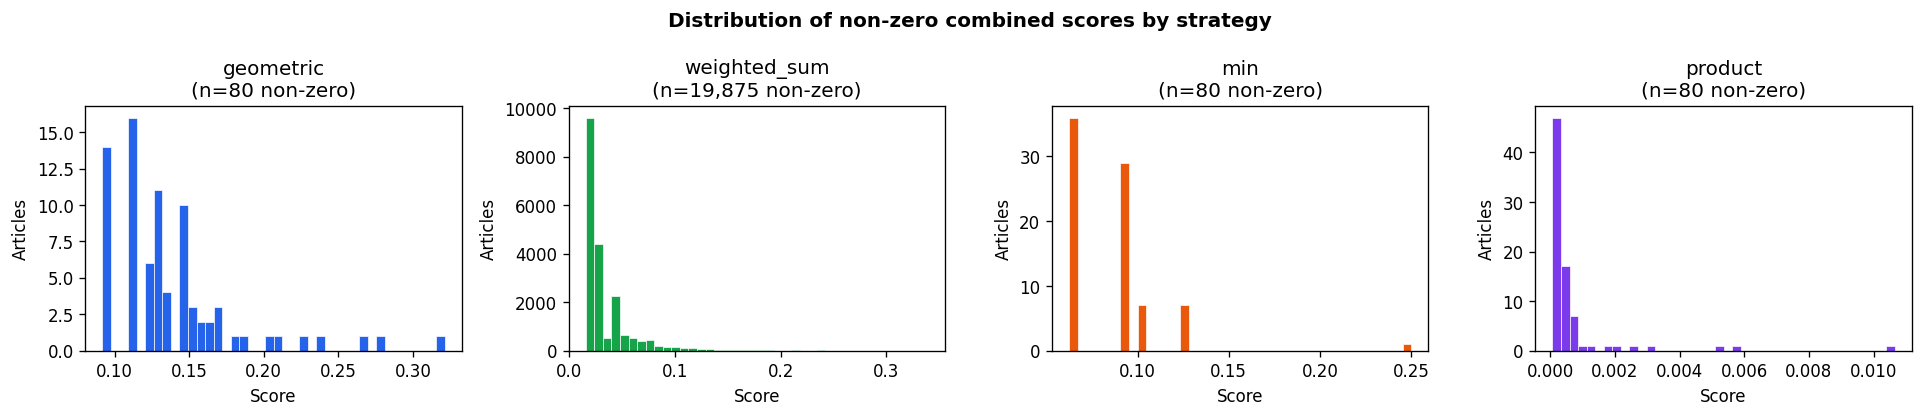

In [9]:
# Side-by-side histograms of the four combined scores
fig, axes = plt.subplots(1, 4, figsize=(16, 3.5), sharey=False)
colors = ["#2563eb", "#16a34a", "#ea580c", "#7c3aed"]

for ax, s, color in zip(axes, strategies, colors):
    col = f"score_{s}"
    data = df_strat[col]
    # Only plot non-zero scores for clarity
    ax.hist(data[data > 0], bins=40, color=color, edgecolor="white", linewidth=0.4)
    ax.set_title(s)
    ax.set_xlabel("Score")
    ax.set_ylabel("Articles")
    n_nz = (data > 0).sum()
    ax.set_title(f"{s}\n(n={n_nz:,} non-zero)")

fig.suptitle("Distribution of non-zero combined scores by strategy", fontsize=12, fontweight="bold")
fig.tight_layout()
plt.show()

In [ ]:
# Custom combination: must hit location AND event_type, then score by impact
def custom_combine(scores):
    """Gate on location + event_type, then score by impact."""
    if scores.get("location", 0) == 0 or scores.get("event_type", 0) == 0:
        return 0.0
    return scores.get("impact", 0)

scored_custom_fn = (
    corpus
    .after(event, months=6)
    .score_grouped(event.term_groups, combine=custom_combine, col="score_custom")
)

df_cfn = scored_custom_fn.to_dataframe()
nz = (df_cfn["score_custom"] > 0).sum()
print(f"Custom strategy: {nz:,} articles pass location+event_type gate")
print(df_cfn["score_custom"].describe().round(4))

## 7 — Diagnostics and visualisation

### 7.1 — Group score distribution (new)

Shows per-group histograms side by side so you can see which group is the bottleneck.

In [ ]:
scored_for_diag = corpus.after(event, months=6).score_grouped(event.term_groups)

fig = group_score_distribution(
    scored_for_diag,
    group_cols=[f"score_{g}" for g in event.term_groups],
    combined_col="score_grouped",
    threshold=0.05,
    bins=35,
)
plt.show()

In [ ]:
# Auto-detect group columns (finds any score_ column not in the known global set)
fig = group_score_distribution(scored_for_diag, threshold=0.02)
plt.show()

### 7.2 — Standard score distribution

In [ ]:
# Distribution of the combined grouped score
fig = score_distribution(
    scored_for_diag,
    score_col="score_grouped",
    threshold=0.05,
    bins=40,
)
plt.title("Combined grouped score — Watersnoodramp 1953")
plt.show()

### 7.3 — Selection report

In [ ]:
# Filter then visualise temporal distribution
filtered_grouped = scored_for_diag.above(0.0, col="score_grouped")
print(f"Grouped (geometric > 0): {len(filtered_grouped):,} articles")

fig = selection_report(corpus, event, filtered_grouped, months=6)
plt.show()

In [ ]:
# Compare: flat score filter vs grouped score filter
filtered_flat    = scored_flat.above(0.05)
filtered_grouped_strict = scored_for_diag.above(0.05, col="score_grouped")

print(f"Flat  (score >= 0.05):          {len(filtered_flat):>6,} articles")
print(f"Grouped (score_grouped >= 0.05): {len(filtered_grouped_strict):>6,} articles")

## 8 — Filtering and export

Use `.above()` to filter on any score column. Per-group scores can also be used directly as gates.

In [ ]:
# Full pipeline: grouped score + gate on specific groups + export
result = (
    corpus
    .after(event, months=6)
    .score_grouped(event.term_groups)            # score all groups
    .above(0.0, col="score_location")            # must mention a location
    .above(0.0, col="score_event_type")          # must mention a flood term
)

print(f"After gating on location AND event_type: {len(result):,} articles")
result.to_dataframe()[[DATE_COL, "score_location", "score_event_type",
                        "score_cause", "score_impact", "score_grouped"]].head(8).round(3)

In [ ]:
# Export to CSV (uncomment to write)
# result.to_csv("watersnood_grouped.csv")

# Export to parquet
# result.to_parquet("watersnood_grouped.parquet")

# Or work with the raw DataFrame
df_result = result.to_dataframe()
print(f"DataFrame shape: {df_result.shape}")
print("Columns:", list(df_result.columns))

## 9 — Comparing flat vs grouped scoring in detail

This section illustrates exactly *why* grouped scoring is smarter.

In [ ]:
# Compute both flat and grouped scores on the same window
comparison = (
    corpus
    .after(event, months=6)
    .score(terms=event.terms)                    # flat -> "score"
    .score_grouped(event.term_groups)            # grouped -> "score_grouped" + per-group
)

df_cmp = comparison.to_dataframe()

# Articles that score well on flat but zero on grouped
# (mentioned many terms but all from the same group)
location_only = df_cmp[
    (df_cmp["score"] > 0.05) &
    (df_cmp["score_grouped"] == 0) &
    (df_cmp["score_location"] > 0)
]
print(f"High flat score but zero grouped (location only): {len(location_only):,} articles")

event_type_only = df_cmp[
    (df_cmp["score"] > 0.05) &
    (df_cmp["score_grouped"] == 0) &
    (df_cmp["score_event_type"] > 0) &
    (df_cmp["score_location"] == 0)
]
print(f"High flat score but zero grouped (event_type only): {len(event_type_only):,} articles")

# Articles that score well on grouped
good = df_cmp[df_cmp["score_grouped"] > 0]
print(f"Non-zero grouped score (evidence in all 4 groups): {len(good):,} articles")

In [ ]:
# Scatter plot: flat score vs grouped score
# Articles with non-zero grouped score are highlighted
fig, ax = plt.subplots(figsize=(8, 5))

mask_zero = df_cmp["score_grouped"] == 0
mask_pos  = df_cmp["score_grouped"] > 0

ax.scatter(
    df_cmp.loc[mask_zero, "score"],
    df_cmp.loc[mask_zero, "score_grouped"],
    s=2, alpha=0.2, color="#d1d5db", label="grouped = 0 (missing a group)",
)
ax.scatter(
    df_cmp.loc[mask_pos, "score"],
    df_cmp.loc[mask_pos, "score_grouped"],
    s=8, alpha=0.7, color="#2563eb", label="grouped > 0 (all groups hit)",
)
ax.set_xlabel("Flat term-coverage score")
ax.set_ylabel("Grouped score (geometric)")
ax.set_title("Flat vs grouped score — Watersnoodramp 1953")
ax.legend(markerscale=3)
plt.tight_layout()
plt.show()

## 10 — Another event: treinkaping bij De Punt (1977)

Demonstrating grouped scoring on a different event type with different group categories.

In [ ]:
kaping = Event.from_json(EVENTS_PATH, "kaping")
print(kaping)
for group, terms in kaping.term_groups.items():
    print(f"  {group:<12}: {', '.join(terms[:6])} ...")

In [ ]:
scored_kaping = (
    corpus
    .after(kaping, months=6)
    .score(terms=kaping.terms)           # flat
    .score_grouped(kaping.term_groups)   # grouped
)

df_k = scored_kaping.to_dataframe()
group_cols_k = [f"score_{g}" for g in kaping.term_groups]

print(f"Window: {len(df_k):,} articles")
for col in group_cols_k + ["score", "score_grouped"]:
    nz = (df_k[col] > 0).sum()
    print(f"  {col:<22}: {nz:>6,} non-zero ({nz/len(df_k)*100:.1f}%)")

In [ ]:
fig = group_score_distribution(
    scored_kaping,
    group_cols=group_cols_k,
    threshold=0.0,
)
fig.suptitle("Treinkaping bij De Punt — per-group score distributions", fontweight="bold")
plt.show()

In [ ]:
# Top-scoring articles for the kaping event
top_k = (
    df_k
    .nlargest(10, "score_grouped")
    [[DATE_COL, "score_location", "score_vehicle", "score_event_type", "score_actors", "score_grouped"]]
)
top_k.round(3)

## 11 — Multiple events in a loop

In [ ]:
all_events = Event.load_all(EVENTS_PATH)

summary_rows = []
for ev in all_events:
    window = corpus.after(ev, months=6)
    n_window = len(window)

    # Flat scoring
    scored_f = window.score(terms=ev.terms)
    n_flat   = (scored_f.to_dataframe()["score"] >= 0.05).sum()

    # Grouped scoring (only if term_groups defined)
    if ev.term_groups:
        scored_g = window.score_grouped(ev.term_groups)
        n_grouped = (scored_g.to_dataframe()["score_grouped"] > 0).sum()
    else:
        n_grouped = None

    summary_rows.append({
        "event":    ev.label,
        "window":   n_window,
        "flat≥0.05": n_flat,
        "grouped>0": n_grouped,
        "ratio": round(n_grouped / n_flat, 2) if (n_grouped and n_flat) else None,
    })

pd.DataFrame(summary_rows).set_index("event")

## 12 — Weighted sum strategy with custom weights

If you want to allow partial matches (e.g. location only or event type only) while still rewarding articles that hit more groups, use `weighted_sum` and tune the weights.

In [ ]:
# Give event_type double weight, impact 1.5x, location and cause 1x
custom_weights = {
    "location":   1.0,
    "event_type": 2.0,
    "cause":      1.0,
    "impact":     1.5,
}

scored_ws = (
    corpus
    .after(event, months=6)
    .score_grouped(
        event.term_groups,
        weights=custom_weights,
        combine="weighted_sum",
        col="score_ws_custom",
    )
)

df_ws = scored_ws.to_dataframe()
print("Weighted sum with custom weights:")
print(df_ws["score_ws_custom"].describe().round(4))
print(f"Non-zero: {(df_ws['score_ws_custom'] > 0).sum():,}")

In [ ]:
# Compare geometric vs weighted_sum filter at threshold 0.05
n_geo = (df_cmp["score_grouped"] >= 0.05).sum()
n_ws  = (df_ws["score_ws_custom"] >= 0.05).sum()
print(f"geometric    >= 0.05: {n_geo:,} articles")
print(f"weighted_sum >= 0.05: {n_ws:,} articles")
print()
print("Geometric is stricter: every group must contribute.")
print("Weighted sum is more lenient: a strong event_type group can compensate for weak location.")

## 13 — Advanced: embedding-based scoring (optional)

Requires `pip install narrative-subcorpora[embeddings]`. Combines grouped keyword filtering with semantic similarity.

Uncomment the cell below if `sentence-transformers` is installed.

In [ ]:
# try:
#     sub_embed = (
#         corpus
#         .after(event, months=6)
#         .score_grouped(event.term_groups)              # grouped keyword filter
#         .above(0.0, col="score_grouped")               # keep only all-group hits
#         .embed("paraphrase-multilingual-MiniLM-L12-v2")
#         .score_similarity(terms=event.terms)           # semantic similarity
#         .score_outlier(method="centroid")              # outlier detection
#         .below(0.6, col="score_outlier")               # remove semantic outliers
#     )
#     df_embed = sub_embed.to_dataframe()
#     print(f"After grouped + embedding filter: {len(df_embed):,} articles")
#     print(df_embed[["score_grouped", "score_similarity", "score_outlier"]].describe().round(3))
# except ImportError:
#     print("sentence-transformers not installed. Run: pip install narrative-subcorpora[embeddings]")
print("(Uncomment the cell above to run embedding-based scoring)")

## Summary

| Feature | Method | When to use |
|---|---|---|
| Flat term coverage | `.score(terms)` | Quick baseline |
| TF-IDF | `.score_tfidf(terms)` | Downweight common terms |
| BM25 | `.score_bm25(terms)` | Length-normalised ranking |
| Term clustering | `.score_cluster(terms)` | Long texts with focused passages |
| Weighted terms | `.score_weighted(weights)` | Known term importance |
| **Grouped (geometric)** | `.score_grouped(term_groups)` | **Require evidence in every semantic category** |
| Grouped (weighted_sum) | `.score_grouped(..., combine='weighted_sum')` | Allow partial matches, reward breadth |
| Grouped (min) | `.score_grouped(..., combine='min')` | Bottleneck logic |
| Semantic similarity | `.embed().score_similarity(terms)` | Semantic relevance beyond keywords |
| Outlier removal | `.embed().score_outlier()` | Clean up false positives |

### Typical pipeline

```python
result = (
    corpus
    .after(event, months=6)
    .score_grouped(event.term_groups)         # score per group + combined
    .above(0.0, col="score_grouped")          # must hit all groups
    .above(0.0, col="score_location")         # optional: explicit location gate
)
result.to_csv("subcorpus.csv")
```

---

## 14 — Active learning

Active learning lets you refine subcorpus selection by labelling a small number of documents and training a classifier to rank the rest. Each labelling round focuses on the documents the model is most uncertain about — this is much more efficient than random sampling.

Install the extra dependencies first (already done in this environment):

```
pip install narrative-subcorpora[active-learning]
```

**Workflow**:
1. Build a candidate pool with keyword scores
2. Create an `ActiveLearner`
3. Call `.annotate()` for interactive labelling, or `.label_batch()` for simulated labelling
4. Call `.retrain()` to update the classifier
5. Call `.status()` to inspect model quality
6. Call `.to_subcorpus()` to export the ranked result

In [ ]:
from narrative_subcorpora import ActiveLearner

# Build a candidate pool (grouped scoring gives richer features)
candidate_pool = (
    corpus
    .after(event, months=6)
    .score(terms=event.terms)
    .score_grouped(event.term_groups)
)

print(f"Candidate pool: {len(candidate_pool):,} articles")
print("Score columns:", [c for c in candidate_pool.to_dataframe().columns if c.startswith("score")])

### 14.1 — Create the learner

`features="scores"` uses the existing score columns (fast). Alternatives:
- `"tfidf"` — build a TF-IDF matrix over the raw text
- `"embeddings"` — use sentence embeddings (call `.embed()` first)

In [ ]:
al = ActiveLearner(candidate_pool, features="scores", random_state=42)
print(al)

### 14.2 — Cold-start batch

Before any labels exist, `next_batch()` returns a mix of top-scored and random documents — this gives a representative first sample.

In [ ]:
batch = al.next_batch(n=10)
print("Cold-start batch indices:", batch)

# Preview each candidate
df_pool = candidate_pool.to_dataframe()
print()
for idx in batch:
    row = df_pool.iloc[idx]
    preview = str(row[TEXT_COL])[:120].replace("\n", " ")
    print(f"[{idx:6d}] score={row['score']:.3f} grouped={row['score_grouped']:.3f}  {preview!r}")

### 14.3 — Simulated labelling (scripted)

In real use you would call `al.annotate(n=10)` for an interactive session. Here we simulate labelling by using the grouped score as a proxy for ground truth.

In [ ]:
# Simulate round 1: label by grouped score threshold
batch1 = al.next_batch(n=12)
labels1 = {
    idx: bool(df_pool.at[idx, "score_grouped"] > 0)
    for idx in batch1
}
print("Round 1 labels:", {k: "✓" if v else "✗" for k, v in labels1.items()})
al.label_batch(labels1)

# Retrain on first batch (need at least one positive + one negative)
try:
    al.retrain()
    print("\nClassifier trained on first batch.")
except RuntimeError as e:
    print(f"\nCould not retrain: {e}")

al.status()

In [ ]:
# Simulate round 2: uncertainty sampling kicks in
batch2 = al.next_batch(n=12)
labels2 = {
    idx: bool(df_pool.at[idx, "score_grouped"] > 0)
    for idx in batch2
}
print("Round 2 labels:", {k: "✓" if v else "✗" for k, v in labels2.items()})
al.label_batch(labels2).retrain()
print()
al.status()

### 14.4 — Interactive annotation (Jupyter)

In a real session, replace the simulated labelling above with:

```python
al.annotate(n=15)   # shows ipywidgets cards with Relevant / Not relevant / Skip / Stop
```

This cell demonstrates the widget interface by running it on a tiny sub-sample.

In [ ]:
# Uncomment to launch the interactive widget interface:
# al.annotate(n=10)

# For a quick non-interactive demo, just show the repr:
print(al)
print()
print("Next uncertainty batch:", al.next_batch(n=5))

### 14.5 — Export and inspect the active-learning scores

In [ ]:
# Export the subcorpus with score_al column
al_sub = al.to_subcorpus()
df_al = al_sub.to_dataframe()

print(f"Subcorpus with score_al: {len(df_al):,} rows")
print()
print("score_al statistics:")
print(df_al["score_al"].describe().round(4))

# Top 10 by active-learning score
top_al = (
    df_al
    .nlargest(10, "score_al")
    [[DATE_COL, "score", "score_grouped", "score_al"]]
)
print()
top_al.round(3)

In [ ]:
# Distribution of score_al vs the grouped score
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Grouped score distribution
axes[0].hist(df_al["score_grouped"], bins=50, color="#d1d5db", edgecolor="white", linewidth=0.3)
axes[0].hist(
    df_al.loc[df_al["score_grouped"] > 0, "score_grouped"],
    bins=40, color="#2563eb", edgecolor="white", linewidth=0.3,
)
axes[0].set_title("Grouped score distribution")
axes[0].set_xlabel("score_grouped")
axes[0].set_ylabel("Articles")

# AL score distribution
axes[1].hist(df_al["score_al"], bins=50, color="#16a34a", edgecolor="white", linewidth=0.3)
axes[1].set_title("Active-learning score distribution")
axes[1].set_xlabel("score_al (classifier probability)")
axes[1].set_ylabel("Articles")

fig.suptitle("Grouped keyword score vs active-learning score", fontweight="bold")
plt.tight_layout()
plt.show()

# Scatter: grouped score vs al score
fig2, ax2 = plt.subplots(figsize=(7, 5))
ax2.scatter(df_al["score_grouped"], df_al["score_al"], s=1, alpha=0.2, color="#2563eb")
ax2.set_xlabel("score_grouped (keyword-based)")
ax2.set_ylabel("score_al (classifier probability)")
ax2.set_title("Grouped keyword score vs active-learning score")
plt.tight_layout()
plt.show()

### 14.6 — Using TF-IDF features

Switch to `features="tfidf"` to build a full TF-IDF matrix over the raw text. This does not depend on pre-computed scores — useful when you want the classifier to discover its own signal.

In [ ]:
# Use TF-IDF features restricted to event seed terms (much faster than full vocab)
al_tfidf = ActiveLearner(
    candidate_pool,
    features="tfidf",
    seed_terms=event.terms,   # restrict vocabulary to seed terms
    random_state=42,
)
print(al_tfidf)

# Simulate two labelling rounds
for round_n, n_labels in enumerate([10, 10], start=1):
    batch = al_tfidf.next_batch(n=n_labels)
    labels = {idx: bool(df_pool.at[idx, "score_grouped"] > 0) for idx in batch}
    al_tfidf.label_batch(labels)
    try:
        al_tfidf.retrain()
        print(f"\nRound {round_n}: retrained on {len(al_tfidf._labels)} labels")
    except RuntimeError as e:
        print(f"\nRound {round_n}: {e}")

al_tfidf.status()

### Active learning summary

| Step | Code |
|---|---|
| Create learner | `al = ActiveLearner(sub, features="scores")` |
| Interactive annotation | `al.annotate(n=10)` |
| Scripted labelling | `al.label_batch({0: True, 1: False, ...})` |
| Retrain classifier | `al.retrain()` |
| Check progress | `al.status()` |
| Export with al scores | `result = al.to_subcorpus()` |

**Tips:**
- Start with `features="scores"` — fastest and often enough.
- If the classifier plateaus, switch to `"tfidf"` or `"embeddings"` for richer signal.
- Aim for at least 20–30 labels (balanced positive/negative) before trusting the ranking.
- Use `al.next_batch()` programmatically to inspect the uncertainty queue without launching the UI.